In [1]:
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
import glob
import mediapipe as mp
from constants import LIPS_POSITIONS, FACE_OVAL,HAND_POSITIONS,HAND_CONNECTIONS
from google.protobuf.json_format import MessageToDict
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks.python.components.containers import NormalizedLandmark

DEFAULT_LEFT_HAND = np.load("defaultLeftHand.npy")
DEFAULT_RIGHT_HAND = np.load("defaultRightHand.npy")


In [17]:
class Drawing:
    def __init__(self):
        self.mpFace = mp.solutions.face_mesh
        self.mpDrawHands = mp.solutions.drawing_utils # Initializing drawing object for hands
        self.mpDrawFace = mp.solutions.drawing_utils # Initializing drawing object for Face
        self.mp_drawing_styles =mp.solutions.drawing_styles
        self.mp_drawing_face = self.mpDrawFace.DrawingSpec(color=(0,0,200),thickness=0,circle_radius=1) #Initializing drawing specifications for face
        self.mp_drawing_hands = self.mpDrawHands.DrawingSpec(color=(255,0,0),thickness=0,circle_radius=1) #Initializing drawing specifications for hand
        self.mpHands = mp.solutions.hands
    def drawLandmarks(self,img,faceLandmarks,handLandmarks,img_size=(700,720)):
        img=img.copy()
        colors={"Right":(100,100,100),"Left":(0,0,255)}
        if faceLandmarks is not None:
            for key in faceLandmarks:
                for var in faceLandmarks[key]:
                    cv2.circle(img, (int(var[0]*img_size[0]),int(var[1]*img_size[1])), 1, (0, 0, 255), -1)
        for key in handLandmarks:
            points={}
            for i,var in enumerate(handLandmarks[key]):
                point = (int(var[0]*img_size[0]),int(var[1]*img_size[1]))
                cv2.circle(img, point, 3, colors[key], -1)
                points[i]=point
            for conn in HAND_CONNECTIONS:
                cv2.line(img, points[conn], points[HAND_CONNECTIONS[conn]], (216, 223, 230), 2)
        return img
        

In [18]:
class HandLandmarkExtractor:
    def getHandLandmarks(self,hands,scale=False,img_size=(700,720)):
        for key in hands:
            list_hand_positions=[]
           # print(type(resultsFace.multi_face_landmarks[0]))

            for cord in HAND_POSITIONS:
                x1,y1,z1=self.__getCoordinates(hands[key],cord,scale,img_size)

                list_hand_positions.append((x1,y1,z1))
            hands[key]= np.array(list_hand_positions)    
        return hands    
    def __getCoordinates(self,landmarks,index,scale,img_size): 
        x=landmarks.landmark[index].x
        y=landmarks.landmark[index].y
        z=landmarks.landmark[index].z
        if scale:
            x=x*img_size[0]
            y=y*img_size[1]
        return x,y,z  

class FaceLandmarkExtractor:
    def __getLipsLandmarks(self,resultsFace,scale=False,img_size=(700,720)):
        list_lips_positions=[]
        if resultsFace.multi_face_landmarks:
            landmarkovi=resultsFace.multi_face_landmarks[0]

            for cord in LIPS_POSITIONS:
                x1,y1,z1=self.__getCoordinates(landmarkovi,cord[0],scale,img_size)
                x2,y2,z2=self.__getCoordinates(landmarkovi,cord[1],scale,img_size)

                avg_x=float((x1+x2)/2)
                avg_y=float((y1+y2)/2)

                list_lips_positions.append((avg_x,avg_y,z1))
        return np.array(list_lips_positions)
 
    def __getOvalFaceLandmarks(self,resultsFace,scale=False,img_size=(700,720)):
        list_face_positions=[]
       # print(type(resultsFace.multi_face_landmarks[0]))
        if resultsFace.multi_face_landmarks:
            landmarkovi=resultsFace.multi_face_landmarks[0]

            for cord in FACE_OVAL:
                x1,y1,z1=self.__getCoordinates(landmarkovi,cord,scale,img_size)

                list_face_positions.append((x1,y1,z1))
        return np.array(list_face_positions)
    
    def getFaceLandmarks(self,resultsFace,scale=False,img_size=(700,720)):
        face_landmarks={}
        face_landmarks["Lips"]=self.__getLipsLandmarks(resultsFace,scale,img_size)
        face_landmarks["Face"]=self.__getOvalFaceLandmarks(resultsFace,scale,img_size)
        return face_landmarks
    
    def __getCoordinates(self,landmarks,index,scale,img_size): 
        x=landmarks.landmark[index].x
        y=landmarks.landmark[index].y
        z=landmarks.landmark[index].z
        if scale:
            x=x*img_size[0]
            y=y*img_size[1]
        return x,y,z  


In [19]:
class LandmarkExtractor:
    def __init__(self):
        self.mpHands = mp.solutions.hands # Load mediapipe hands module
        self.mpFace = mp.solutions.face_mesh
        self.hands = self.mpHands.Hands( # Initialize hands model
            max_num_hands=2,
            model_complexity=1,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5,
            static_image_mode=False)
        
         # Load mediapipe face module
        self.faces = self.mpFace.FaceMesh( # Initialize Face model
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5,
            static_image_mode=False)
        self.handLandmarkExtractor=HandLandmarkExtractor()
        self.faceLandmarkExtractor=FaceLandmarkExtractor()

    def findHands(self,img):
        hands={}
        imgRGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # Transform to RGB
        results = self.hands.process(imgRGB) # Feeding image through Hands model
        if results.multi_handedness!=None:
            for i,hand in enumerate(results.multi_handedness):
                if hand.classification[0].label == "Left":
                    handType="Right"
                else:
                    handType="Left"
                hands[handType]=results.multi_hand_landmarks[i]


        return hands # Returning values from model prediction
    
    def findFace(self, img):
        imgRGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) # Transform image to RGB
        results = self.faces.process(imgRGB) # Feeding image through Face model
        return results
        
    def getFaceLandmarks(self,resultsFace,scale=False,img_size=(700,720)):
        return self.faceLandmarkExtractor.getFaceLandmarks(resultsFace,scale,img_size)
    def getHandLandmarks(self,resultsHand,scale=False,img_size=(700,720)):
        return self.handLandmarkExtractor.getHandLandmarks(resultsHand,scale,img_size)

In [109]:
class VideoLoader:
    def __init__(self):
        self.fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        self.landmark_extractor=LandmarkExtractor()
        self.drawing = Drawing()
    
    def __processFrame(self,frame):
        resultsFace=self.landmark_extractor.findFace(frame) #using function defined above to detect facial landmarks in a frame (findFace)
        faceLandmarks=self.landmark_extractor.getFaceLandmarks(resultsFace)
        
        resultsHands=self.landmark_extractor.findHands(frame)
        handLandmarks=self.landmark_extractor.getHandLandmarks(resultsHands)
        
        return faceLandmarks,handLandmarks
    def writeFeatures(self,path,features,output_path):
        outf = cv2.VideoWriter(output_path,self.fourcc, 15,(700,720))

        frames = self.loadVideo(path)
        #feature=features[50]

        #print(type(feature['faceLips']))
        #print(feature['faceLips'][:,0])
        faceLandmarks={}
        handLandmarks={}

        for i,feature in enumerate(features):
            frame=frames[i]
            faceLandmarks["Lips"]=feature['faceLips']
            faceLandmarks["Face"]=feature['faceOval']
            handLandmarks["Left"]=feature['handLeft']
            handLandmarks["Right"]=feature['handRight']
            outf.write(self.drawing.drawLandmarks(frame.copy(),faceLandmarks,handLandmarks))
            #out.write(self.drawing.drawLandmarks(frames[i].copy(),faceLandmarks,handLandmarks)) #drawing landmarks on frames by using function defined above (drawLadmarks)
        outf.release()

    def loadVideo(self,path,output_path=None):
        
        cap = cv2.VideoCapture(path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        step = fps/15
        if output_path is not None:
            out = cv2.VideoWriter(output_path,self.fourcc, 15,(700,720))

        frame_index = 0
        next_frame_to_use = 0.0

        frames=[]  
        while(True):
            ret, frame = cap.read() #reading frames
            if not ret:
                break
            if ret: #if frame exist ret=True, otherwise False
                if frame_index >= round(next_frame_to_use):
                    frame=frame[:, 300:1000,:] #cropping image, retainig all 3 rgb channels
                    frames.append(frame)
                    
                    if output_path is not None:
                        faceLandmarks,handLandmarks = self.__processFrame(frame)
                        out.write(self.drawing.drawLandmarks(frame.copy(),faceLandmarks,handLandmarks)) #drawing landmarks on frames by using function defined above (drawLadmarks)
        
                    next_frame_to_use += step
            frame_index += 1
        if output_path is not None:
            out.release() #close writing stream
        return frames

In [116]:
class HandState:
    def __init__(self, side, default):
        self.side = side  # "Left" or "Right"
        self.default = default
        self.last = None
        self.missing_count = 0

    def update(self, handLandmarks, features):
        key = f"hand{self.side}"
        if self.side in handLandmarks:
            current = handLandmarks[self.side]
            features[-1][key] = current

            if 0 < self.missing_count <= 25 and self.last is not None:
                for i in range(1, self.missing_count + 1):
                    features[-(i + 1)][key] = self.last
            self.missing_count = 0
            self.last = current
        else:
            features[-1][key] = self.default
            self.missing_count += 1

class FeatureExtraction:
    def __init__(self):
        self.landmark_extractor=LandmarkExtractor()
        self.video_loader=VideoLoader()
    
    def __processFrame(self,frame):
        resultsFace=self.landmark_extractor.findFace(frame) #using function defined above to detect facial landmarks in a frame (findFace)
        faceLandmarks=self.landmark_extractor.getFaceLandmarks(resultsFace)
        
        resultsHands=self.landmark_extractor.findHands(frame)
        handLandmarks=self.landmark_extractor.getHandLandmarks(resultsHands)
        
        return faceLandmarks,handLandmarks
    
    def extractFromVideo(self,path):
        timestamp=0.0
        left_hand = HandState("Left", DEFAULT_LEFT_HAND)
        right_hand = HandState("Right", DEFAULT_RIGHT_HAND)
        features=[]
        frames = self.video_loader.loadVideo(path)
        for r,frame in enumerate(frames):
            frameFeature={}
            faceLandmarks,handLandmarks = self.__processFrame(frame)
            frameFeature["timestamp"]=timestamp

            if faceLandmarks:
                frameFeature["faceLips"] = faceLandmarks["Lips"]
                frameFeature["faceOval"] = faceLandmarks["Face"]
            
            features.append(frameFeature)

            left_hand.update(handLandmarks, features)
            right_hand.update(handLandmarks, features)                
        
            timestamp+=(1/15)
            
        print(r)
        return features
    

In [117]:
videoLoader = VideoLoader()
featureExtraction = FeatureExtraction()

In [118]:
features = featureExtraction.extractFromVideo("../../ASLens - test data 1/8kAWy2YodzQ-1-rgb_front.mp4")

1754


In [119]:
videoLoader.writeFeatures("../../ASLens - test data 1/8kAWy2YodzQ-1-rgb_front.mp4", features, output_path="novi113.mp4")

In [74]:
frames=videoLoader.loadVideo("../../ASLens - test data 1/8kAWy2YodzQ-1-rgb_front.mp4",output_path='new11.mp4')

In [101]:
features[-1]

{'faceLips': array([[ 0.47971705,  0.36958578,  0.00687447],
        [ 0.48149449,  0.36853543,  0.00175637],
        [ 0.48451656,  0.36766766, -0.00408619],
        [ 0.48855862,  0.3664867 , -0.00948065],
        [ 0.49414991,  0.36579576, -0.01417825],
        [ 0.50032511,  0.3661841 , -0.01620968],
        [ 0.50698116,  0.36553687, -0.01686146],
        [ 0.51398793,  0.36595581, -0.01492166],
        [ 0.51958525,  0.36685789, -0.01166756],
        [ 0.52411863,  0.3675568 , -0.00774223],
        [ 0.52658084,  0.36857513, -0.00357549],
        [ 0.52288872,  0.36957316, -0.00646602],
        [ 0.51868924,  0.37033522, -0.01024363],
        [ 0.51297259,  0.37149826, -0.01294625],
        [ 0.5067054 ,  0.37239063, -0.01467434],
        [ 0.5005236 ,  0.37261871, -0.01387239],
        [ 0.49467269,  0.37249939, -0.01212157],
        [ 0.48938338,  0.37179053, -0.00793156],
        [ 0.48521592,  0.37085305, -0.00357184],
        [ 0.48238124,  0.37032983,  0.00215533]]),
 'face

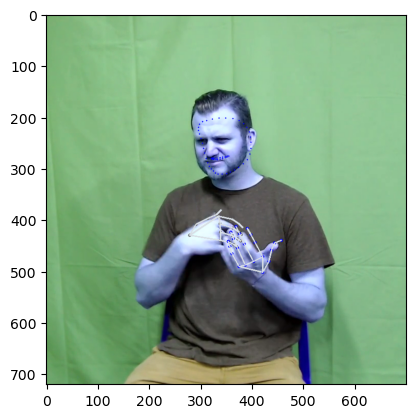

In [18]:
drawing = Drawing()
faceLandmarks,handLandmarks = videoLoader.processFrame(frames[50])
plt.imshow(drawing.drawLandmarks(frames[50].copy(),faceLandmarks,handLandmarks))

In [19]:
(resultsFace[:,0]+resultsFace[:,1])/2

NameError: name 'resultsFace' is not defined

In [210]:
tada ={1:3,2:3}

In [212]:
for i in tada:
    print(i)

1
2


In [ ]:
mp.